# Estimation of erosion risk based on bare soil periods and digital elevation model slope
The universal soil loss equation ([Wischmeier and Smith 1978](https://books.google.hu/books?hl=en&lr=&id=rRAUAAAAYAAJ&oi=fnd&pg=PA5&dq=wischmeier+smith+soil+loss+equation+1978&ots=cwkwsQrpTX&sig=SQytToOJL1zvjm7sA24qQzAc0Dc&redir_esc=y#v=onepage&q=wischmeier%20smith%20soil%20loss%20equation%201978&f=false)) calculates soil loss per unit area based on precipitation and runoff, soil erodibility, slope length, slope steepness, land cover and management and support practices.
This notebook shows how to calculate a simplified estimate based on a combination of terrain steepness and the number of days without vegetation cover. It aims to illustrate the accessibility of such datasets in the Copernicus Data Space Ecosystem, which can be complemented by local information on the other factors such as precipitation or soil properties.
The notebook uses the Sentinel Hub APIs to access the data and evaluation scripts to perform the calculations on the server side. No downloading of data is needed. For a more detailed introduction to the Sentinel Hub APIs, please refer to [this document](https://dataspace.copernicus.eu/news/2023-9-28-accessing-sentinel-mission-data-new-copernicus-data-space-ecosystem-apis).


In the first step, the dependencies are imported, including getpass for managing credentials, matplotlib for visualization of images, and a number of functions from the Sentinel Hub package.

In [ ]:
import getpass

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubRequest,
    SentinelHubStatistical,
    SHConfig,
)

### Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained by navigating to your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevent [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specifically for accessing Copernicus Data Space Ecosystem data collections. This is useful because changes to the the `Config` class are usually only made temporarily in your notebook. If you save the configuration to your profile, you do not have to generate new credentials or overwrite/change the default profile every time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [ ]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
# config.sh_client_id = getpass.getpass("enter your user ID")
# config.sh_client_secret = getpass.getpass("enter your client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can uncomment and run the below cell by entering the profile name as a string (which is `cdse` in our case, feel free to change this when you save your profile).

In [ ]:
# config = SHConfig("cdse")

Here we define the bounding box for our analysis. This area of interest is a network of agricultural fields on complex topography near Somogybabod, south-west Hungary. The area is affected by erosion, occasionally forming spectacular gullies ([Jakab & Szalai 2015](https://link.springer.com/chapter/10.1007/978-3-319-08997-3_12)). The area of interest is the blue rectangle in the right center. You can take a closer look of the place in Copernicus Browser at [this link](https://link.dataspace.copernicus.eu/o4y). Of course, you can define an different bounding box for your own area of interest in [Copernicus Browser](https://browser.dataspace.copernicus.eu/) or [bbox finder](http://bboxfinder.com).

![Sentinel-2 Quarterly Mosaic, June 2023](./img/erosion_aoi_location_res.jpg)

In [ ]:
bbox = BBox((17.768669, 46.629812, 17.851925, 46.719976), crs=CRS.WGS84).transform(3035)
time_interval = "2023-04-01", "2023-09-01"
resolution = (50, 50)

## Get the number of bare soil days over a certain time interval

[Evalscripts](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html) are short sections of code that perform a pixel-by-pixel mathematical operation on the spectral bands of an image or series of images. More information on evalscripts functions and features can be found in the documentation [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript/Functions.html) and [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript/V3.html) respectively.

 This evalscript combines cloud masking based on [scene classification](https://www.sentinel-hub.com/faq/#how-get-s2a-scene-classification-sentinel-2) of Level-2 pixels with bare soil detection based on the [Barren Soil Custom Script](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/barren_soil/), and outputs counts of days of bare and vegetated soil within the requested time frame. 

In [ ]:
evalscript_bare_soil = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B04", "B08", "B11", "B12", "SCL", "dataMask"],
    output: { bands: 3, sampleType: "UINT16" },
    mosaicking: "ORBIT",
  };
}

function isCloud(sample) {
  // Define codes as invalid:
  const invalid = [
    0, // NO_DATA
    1, // SATURATED_DEFECTIVE
    3, // CLOUD_SHADOW
    7, // CLOUD_LOW_PROBA
    8, // CLOUD_MEDIUM_PROBA
    9, // CLOUD_HIGH_PROBA
    10, // THIN_CIRRUS
  ];
  return !invalid.includes(sample.SCL);
}

function evaluatePixel(samples) {
  let [nBare, nNonBare, nCloud] = [0, 0, 0];
  for (let i = 0; i < samples.length; i++) {
    let s = samples[i];
    if (s.dataMask === 0) {
      continue;
    }
    if (isCloud(s)) {
      nCloud++;
      continue;
    }
    // bareness index
    let mbi =
      (2.5 * (s.B11 + s.B04 - (s.B08 + s.B02))) /
      (s.B11 + s.B04 + (s.B08 + s.B02));
    if (mbi > 0) {
      nBare++;
    } else {
      nNonBare++;
    }
  }
  return [nBare, nNonBare, nCloud];
}

"""

In the next step, we define a Sentinel Hub [Process API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process.html) request. For this request, we use the `evalscript` defined above for counting bare soil days, together with the bounding box and time range already defined. The authorization for this request is handled via the `config`.

For additional information on the Process API you can find documentation and additional code examples [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Process/Examples/S2L2A.html).

In [ ]:
request = SentinelHubRequest(
    evalscript=evalscript_bare_soil,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                "s2l2a", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.MOST_RECENT,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=resolution,
    config=config,
    data_folder="./data",
)

In [ ]:
bare_soil = request.get_data(save_data=True)[0]

Then we calculate the ratio of bare soil days to total cloud-free days for each pixel: this bare soil ratio is our final output parameter. We use [matplotlib pyplot](https://matplotlib.org/3.5.3/api/pyplot_summary.html) to visualize an image of this index for the study area.

Blue areas have no bare soil but are covered by vegetation during the whole studied period.
Yellow areas have high bare soil ratio, potentially open soil during the whole studied period.

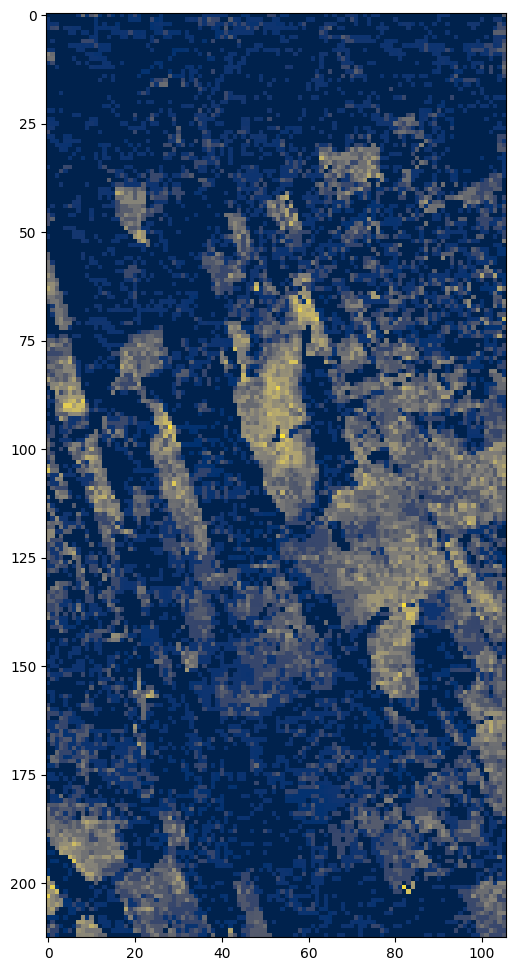

In [ ]:
total_clear = bare_soil[:, :, 1] + bare_soil[:, :, 0]
bare_ratio = bare_soil[:, :, 0] / total_clear

# show image of bare soil ratio for the area of interest.

plt.figure(figsize=(12, 12))
plt.imshow(bare_ratio, cmap="cividis");

## Get terrain slope for the same area
Copernicus Data Space Ecosystem allows users to upload their own data in a [Cloud Optimized Geotiff (COG)](https://www.cogeo.org/) format, ingesting it with the [Bring Your Own COG ("BYOC") API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Byoc.html). Once a dataset is ingested, in can be made available privately or publicly, and other Sentinel Hub API requests can access the data collection via its BYOC collection ID ([example here](https://github.com/eu-cdse/notebook-samples/blob/main/sentinelhub/cloudless_process_api.ipynb))

Terrain slopes were calculated using the GDALDEM `slope` function, running on the full global 30 meter [Copernicus DEM dataset](https://documentation.dataspace.copernicus.eu/Data/ComplementaryData/Additional.html#copernicus-digital-elevation-model-cop-dem). The following command was used: 

    `gdaldem slope input_dem.tif slope-byoc.tif -of COG -co COMPRESS=DEFLATE -co BLOCKSIZE=1024 -co RESAMPLING=NEAREST -co OVERVIEWS=IGNORE_EXISTING` 

This dataset of slopes is made available in Copernicus Data Space Ecosystem as a public BYOC collection, making streamlined querying and processing possible.

Here we also define a simple evalscript that returns slope angle values directly from the dataset

In [ ]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["slope", "dataMask"],
    output: { bands: 1, sampleType: "FLOAT32" },
  };
}

function evaluatePixel(samples) {
  return [samples.slope];
}
"""

Then we define a Sentinel Hub Process API request again that calls data from the custom BYOC collection holding the slope data. We use the previously defined bounding box and time interval.

In [ ]:
slope_collection = DataCollection.define_byoc(
    "f57baa78-b28b-4bf1-b6b1-cc26d292007e", service_url=config.sh_base_url
)
slope_request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=slope_collection,
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.MOST_RECENT,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=resolution,
    config=config,
    data_folder="./data",
)

We collect raster slope data of the area of interest and timeframe from the Process API request into a the variable `slope`

In [ ]:
slope = slope_request.get_data(save_data=True)[0]

We visualize an image of the `slope`variable using pyplot again.

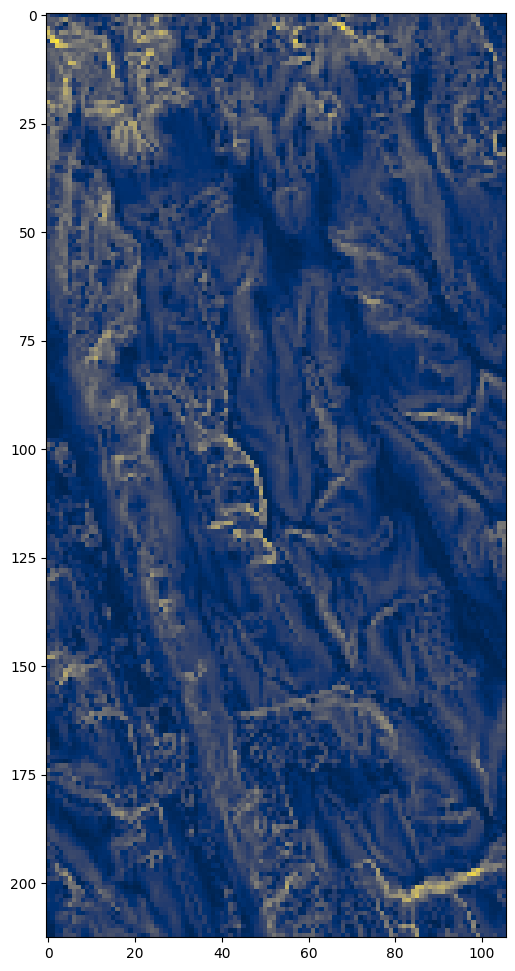

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(slope, cmap="cividis");

This image shows the terrain patterns and drainage network of the area. Forested areas have noisy topography, and forest edges stand out as narrow lines of steeper slopes, due to constraints of the [Copernicus 30 DEM terrain dataset](https://spacedata.copernicus.eu/documents/20123/121239/GEO1988-CopernicusDEM-SPE-002_ProductHandbook_I4.0.pdf).

## Calculate relative erosion risk
To estimate erosion risk at a specific location and time, we simply calculate the product of the terrain slope and the ratio of days with bare soil. The respective weighting of these two parameters can be modified by the user.

In [ ]:
WEIGHT_BARE_SOIL = 1
WEIGHT_SLOPE = 1
relative_erosion_risk = (slope / 90) * WEIGHT_SLOPE * bare_ratio * WEIGHT_BARE_SOIL

To optimize the visualization, the minimum and maximum of the erosion risk within the area and timeframe of interest is calculated below. You can set the visualization parameters `vmin` and `vmax` according to the minimum and maximum statistics to scale visualization of the result. Finally, an image is created showing the  estimated erosion risk for each pixel.

In [ ]:
relative_erosion_risk.min()

0.0

In [ ]:
relative_erosion_risk.max()

0.02239825470106942

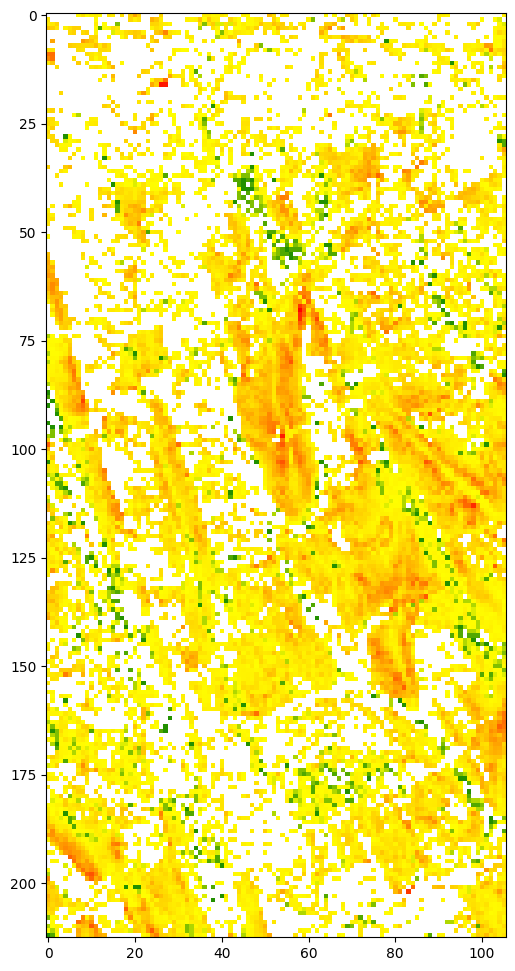

In [ ]:
# First we define a colormap. White for risk of zero, green for low risk, yellow for moderate, red for high.
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "green yellow red",
    [
        (0, (1, 1, 1)),
        (0.001, (0, 0.5, 0)),
        (relative_erosion_risk.max(), (1, 1, 0)),
        (1, (1, 0, 0)),
    ],
    N=256,
)


plt.figure(figsize=(12, 12))

plt.imshow(relative_erosion_risk, cmap=cmap)

Now we prepare a side-by-side comparison of a true colour image of the same area and the erosion risk estimation map. The true colour image will be based on the [quarterly cloudless Sentinel-2 mosaic](https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel2.html#sentinel-2-level-3-quarterly-mosaics) of the same area and time - another public BYOC collection. The visualization is done via a Process API request, based on the data source collection and the evalscript for the true colour visualisation.

First we define the data collection - the cloudless mosaic.

In [ ]:
S2l3_cloudless_mosaic = DataCollection.define_byoc(
    collection_id="5460de54-082e-473a-b6ea-d5cbe3c17cca"
)

Then we define an evalscript for the true color image.

In [ ]:
evalscript_true_color = """
//VERSION=3
function setup() {
  return {
    input: ["B04","B03","B02", "dataMask"],
    output: { bands: 4 }
  };
}

// Contrast enhance / highlight compress

const maxR = 3.0; // max reflectance
const midR = 0.13;
const sat = 1.2;
const gamma = 1.8;
const scalefac = 10000;

function evaluatePixel(smp) {
  const rgbLin = satEnh(sAdj(smp.B04/scalefac), sAdj(smp.B03/scalefac), sAdj(smp.B02/scalefac));
  return [sRGB(rgbLin[0]), sRGB(rgbLin[1]), sRGB(rgbLin[2]), smp.dataMask];
}

function sAdj(a) {
  return adjGamma(adj(a, midR, 1, maxR));
}

const gOff = 0.01;
const gOffPow = Math.pow(gOff, gamma);
const gOffRange = Math.pow(1 + gOff, gamma) - gOffPow;

function adjGamma(b) {
  return (Math.pow((b + gOff), gamma) - gOffPow)/gOffRange;
}

// Saturation enhancement
function satEnh(r, g, b) {
  const avgS = (r + g + b) / 3.0 * (1 - sat);
  return [clip(avgS + r * sat), clip(avgS + g * sat), clip(avgS + b * sat)];
}

function clip(s) {
  return s < 0 ? 0 : s > 1 ? 1 : s;
}

//contrast enhancement with highlight compression
function adj(a, tx, ty, maxC) {
  var ar = clip(a / maxC, 0, 1);
  return ar * (ar * (tx/maxC + ty -1) - ty) / (ar * (2 * tx/maxC - 1) - tx/maxC);
}

const sRGB = (c) => c <= 0.0031308 ? (12.92 * c) : (1.055 * Math.pow(c, 0.41666666666) - 0.055);"""

Finally, we create a Process API request to get a true color image for the study area.

In [ ]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=S2l3_cloudless_mosaic,
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    resolution=(10, 10),
    config=config,
    data_folder="./data",
)

We load the data from the request into a variable again.

In [ ]:
true_color_imgs = request_true_color.get_data(save_data=True)
image = true_color_imgs[0]

And we create a graphic of two subplots, one from the true colour image defined above, and the other from the scaled soil erosion risk map.

In [ ]:
plt.figure(figsize=(12, 24))

plt.subplot(121)
plt.imshow(image)

plt.subplot(122)
plt.imshow(relative_erosion_risk, cmap=cmap)

plt.show

The resulting map of estimated erosion risk shows that forested areas have a low erosion risk, although they often occupy the steep slopes unsuitable for cultivation. The agricultural areas with steeper slopes near the valleys sides have the highest erosion risk according to this simple model.

This notebook shows how to use the Copernicus Data Space Ecosystem Process API to integrate image and DEM data. The API allows querying a time series of images to quantify the number of days with vegetation and bare soil respectively. Also, DEM slopes from a custom data collection can be queried from the same area. Finally these can be combined in a data product that provides a first estimation of soil erosion risk for the date and location. This workflow can be carried out anywhere in the world as a first check, but for quantitative analysis purposes, must be complemented by local information on precipitation, cultivation and soil type.

# Appendix - alternative formulation of the same script for different ways of use
These additional small code examples can serve as a basis when you are developing your own workflow using the erosion risk estimation algorithm. The single evalscript approach allows embedding in an API request for streamlined access. Additionally, with some reformulation the script is directly compatible with the Statistics API, allowing you to create a time series or a histogram.
## Same output as before but in one single evalscript using data fusion

In [ ]:
fusion_evalscript = """
//VERSION=3
function setup() {
  return {
    input: [
      {
        datasource: "s2",
        bands: ["B02", "B04", "B08", "B11", "B12", "SCL", "dataMask"],
        mosaicking: "ORBIT",
      },
      {
        datasource: "slope",
        bands: ["slope", "dataMask"],
        mosaicking: "SIMPLE",
      },
    ],
    output: { bands: 1, sampleType: "FLOAT32" },
  };
}

const WEIGHT_BARE_SOIL = 1;
const WEIGHT_SLOPE = 1;

function isCloud(sample) {
  // Define codes as invalid:
  const invalid = [
    0, // NO_DATA
    1, // SATURATED_DEFECTIVE
    3, // CLOUD_SHADOW
    7, // CLOUD_LOW_PROBA
    8, // CLOUD_MEDIUM_PROBA
    9, // CLOUD_HIGH_PROBA
    10, // THIN_CIRRUS
  ];
  return !invalid.includes(sample.SCL);
}

function evaluatePixel(samples) {
  let [nBare, nNonBare, nCloud] = [0, 0, 0];
  for (let i = 0; i < samples.s2.length; i++) {
    let s = samples.s2[i];
    if (s.dataMask === 0) {
      continue;
    }
    if (isCloud(s)) {
      nCloud++;
      continue;
    }
    // bareness index
    let mbi =
      (2.5 * (s.B11 + s.B04 - (s.B08 + s.B02))) /
      (s.B11 + s.B04 + (s.B08 + s.B02));
    if (mbi > 0) {
      nBare++;
    } else {
      nNonBare++;
    }
  }
  const bareRatio = nBare / (nBare + nNonBare);
  const normalizedSlope = samples.slope[0].slope / 90;
  const erosionRisk =
    bareRatio * WEIGHT_BARE_SOIL * normalizedSlope * WEIGHT_SLOPE;
  return [erosionRisk];
}

"""

In [ ]:
request_fusion = SentinelHubRequest(
    evalscript=fusion_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                "s2l2a", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.MOST_RECENT,
            identifier="s2",
        ),
        SentinelHubRequest.input_data(
            data_collection=slope_collection,
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.MOST_RECENT,
            identifier="slope",
        ),
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=resolution,
    config=config,
    data_folder="./data",
)

In [ ]:
erosion_risk = request_fusion.get_data(save_data=True)[0]

In [ ]:
erosion_risk.max()

0.022398256

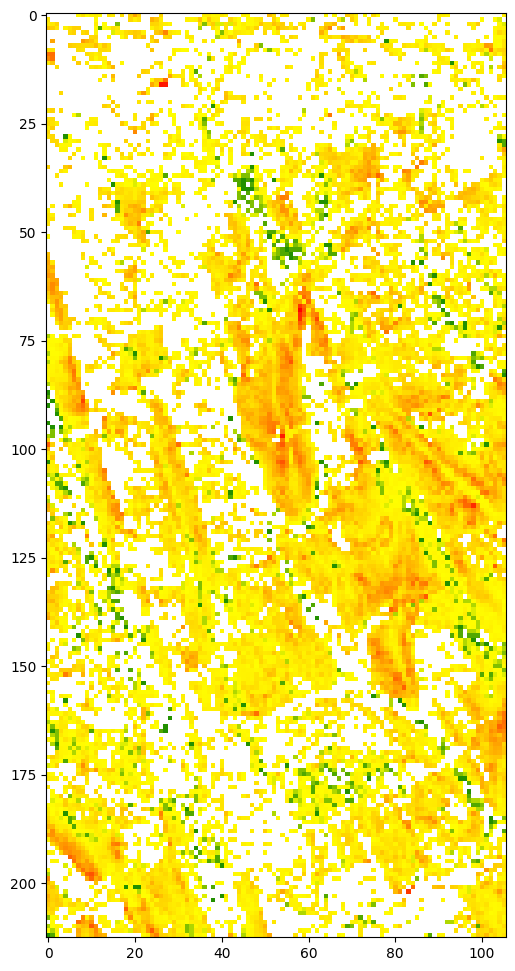

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(erosion_risk, cmap=cmap);

## Adjusting the data fusion evalscript for statistics API
[Statistics API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html) is an API that allows calculation of statistical parameters of pixels or pixel time series in a streamlined way, directly outputting a table of the requested statistical metrics. These can be calculated both for an area of interest on a single image and a time series of images. For more details on Statistics API, check [the documentation](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html) and some [code examples here](https://documentation.dataspace.copernicus.eu/notebook-samples/sentinelhub/air_pollution_statistics.html).

In order to run Statistics API requests with this evalscript, we need to modify it to provide erosion risk as the default output, complemented with a data mask.  

In [ ]:
stat_evalscript = """
//VERSION=3
function setup() {
  return {
    input: [
      {
        datasource: "s2",
        bands: ["B02", "B04", "B08", "B11", "B12", "SCL", "dataMask"],
        mosaicking: "ORBIT",
      },
      {
        datasource: "slope",
        bands: ["slope", "dataMask"],
        mosaicking: "SIMPLE",
      },
    ],
    output: [
      {
        id: "erosion_risk",
        bands: ["ErosionRisk"]
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  };
}

const WEIGHT_BARE_SOIL = 1;
const WEIGHT_SLOPE = 1;

function isCloud(sample) {
  // Define codes as invalid:
  const invalid = [
    0, // NO_DATA
    1, // SATURATED_DEFECTIVE
    3, // CLOUD_SHADOW
    7, // CLOUD_LOW_PROBA
    8, // CLOUD_MEDIUM_PROBA
    9, // CLOUD_HIGH_PROBA
    10, // THIN_CIRRUS
  ];
  return !invalid.includes(sample.SCL);
}

function evaluatePixel(samples) {
  let [nBare, nNonBare, nCloud] = [0, 0, 0];
  for (let i = 0; i < samples.s2.length; i++) {
    let s = samples.s2[i];
    if (s.dataMask === 0) {
      continue;
    }
    if (isCloud(s)) {
      nCloud++;
      continue;
    }
    // bareness index
    let mbi =
      (2.5 * (s.B11 + s.B04 - (s.B08 + s.B02))) /
      (s.B11 + s.B04 + (s.B08 + s.B02));
    if (mbi > 0) {
      nBare++;
    } else {
      nNonBare++;
    }
  }
  const bareRatio = nBare / (nBare + nNonBare);
  const normalizedSlope = samples.slope[0].slope / 90;
  const erosionRisk =
    bareRatio * WEIGHT_BARE_SOIL * normalizedSlope * WEIGHT_SLOPE;
  return {
      erosion_risk: [erosionRisk],
      dataMask: [samples.slope[0].dataMask]
    };
}

"""

Now that we have the modified evalscript, we define a process API request. In order to save data processing capacity, first we define a smaller bounding box of a few parcels.
For the Process API request, it is important that we set the `aggregation_interval` to P1M, which means aggregation for monthly intervals. We then define the two sources of input data: Sentinel-2 L2A and the slope dataset defined from the BYOC collection before.

In [ ]:
smaller_bbox = BBox(
    (7.485831, 48.563885, 7.491689, 48.566001), crs=CRS.WGS84
).transform(3035)

erosion_stat = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=stat_evalscript,
        time_interval=time_interval,
        aggregation_interval="P1M",
        resolution=(20, 20),
    ),
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                "s2l2a", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.MOST_RECENT,
            identifier="s2",
        ),
        SentinelHubRequest.input_data(
            data_collection=slope_collection,
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.MOST_RECENT,
            identifier="slope",
        ),
    ],
    bbox=bbox,
    config=config,
)

In [ ]:
erosion_stats = erosion_stat.get_data()

The raw output of the statistics API is a set of statistics (min, max, mean, stDev, samplecount, and nodatacount), calculated for each month.

In [ ]:
erosion_stats

[{'data': [{'interval': {'from': '2023-04-01T00:00:00Z',
     'to': '2023-05-01T00:00:00Z'},
    'outputs': {'erosion_risk': {'bands': {'ErosionRisk': {'stats': {'min': 0.0,
         'max': 0.04839124530553818,
         'mean': 0.00120173637284527,
         'stDev': 0.0032264424239037037,
         'sampleCount': 141512,
         'noDataCount': 0}}}}}},
   {'interval': {'from': '2023-05-01T00:00:00Z', 'to': '2023-06-01T00:00:00Z'},
    'outputs': {'erosion_risk': {'bands': {'ErosionRisk': {'stats': {'min': 0.0,
         'max': 0.03731662034988403,
         'mean': 0.0009038782154514808,
         'stDev': 0.002478568673644408,
         'sampleCount': 141512,
         'noDataCount': 0}}}}}},
   {'interval': {'from': '2023-06-01T00:00:00Z', 'to': '2023-07-01T00:00:00Z'},
    'outputs': {'erosion_risk': {'bands': {'ErosionRisk': {'stats': {'min': 0.0,
         'max': 0.08981089293956757,
         'mean': 0.001446468833208199,
         'stDev': 0.004060823818060092,
         'sampleCount': 1

In [ ]:
# define functions to extract statistics for all acquisition dates


def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["ErosionRisk"]["stats"]
        if stats["sampleCount"] != stats["noDataCount"]:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name not in ["sampleCount", "noDataCount"]:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

In [ ]:
result_df1 = read_acquisitions_stats(erosion_stats[0]["data"])
result_df1

,date,erosion_risk_min,erosion_risk_max,erosion_risk_mean,erosion_risk_stDev
0,2023-04-01,0.0,0.048391,0.001202,0.003226
0,2023-05-01,0.0,0.037317,0.000904,0.002479
0,2023-06-01,0.0,0.089811,0.001446,0.004061
0,2023-07-01,0.0,0.071374,0.002237,0.005134
0,2023-08-01,0.0,0.068359,0.002089,0.005595


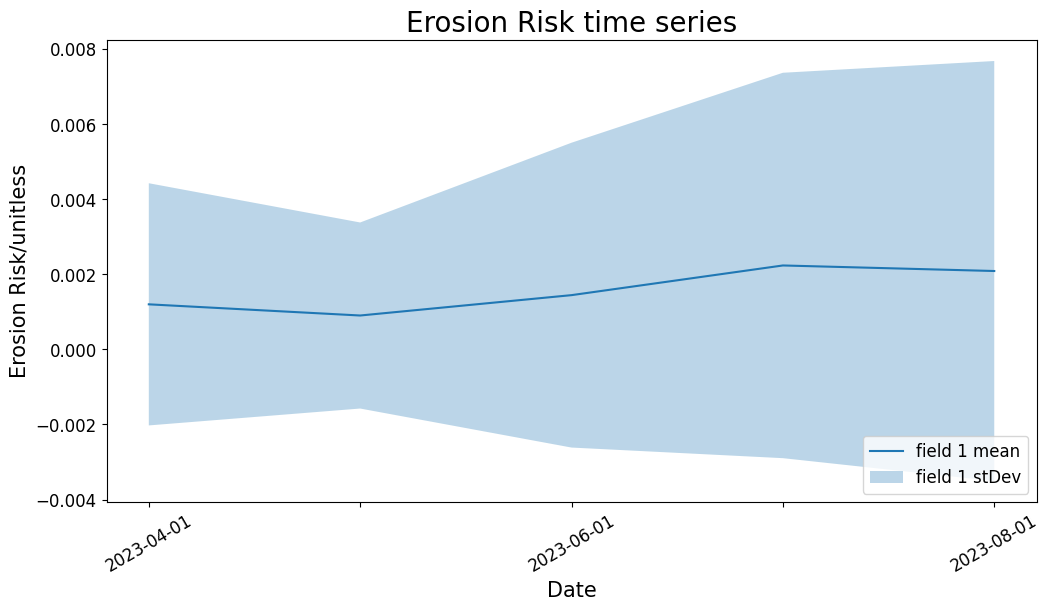

In [ ]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))
t1 = result_df1["date"]
mean_field1 = result_df1["erosion_risk_mean"]
std_field1 = result_df1["erosion_risk_stDev"]
ax_stat.plot(t1, mean_field1, label="field 1 mean")
ax_stat.fill_between(
    t1,
    mean_field1 - std_field1,
    mean_field1 + std_field1,
    alpha=0.3,
    label="field 1 stDev",
)
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("Erosion Risk/unitless", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("Erosion Risk time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::2]:
    label.set_visible(False)